# The Focus of This Post

### Obtaining the Data & Data Pre-processing

In [1]:
from sys import path
from os.path import join

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score




csv_path = join(path[0], 'boardgamegeek-reviews')
csv_path = join(csv_path, 'bgg-13m-reviews.csv')

print(csv_path)

/Users/zmo/here/jupyter/data mining/project/boardgamegeek-reviews/bgg-13m-reviews.csv


In [2]:
def Format_DF(df):
        
    def Has_Letters(in_str): return in_str.lower().islower()

    
    def Is_RomanAlphabet(in_str):
        try: in_str.encode(encoding='utf-8').decode('ascii')
        except UnicodeDecodeError: return False
        return True
    
    
    # only keeps 'comment' and 'rating' columns, filling NaNs with ''
    df = df[['comment', 'rating']].copy().fillna('')
    # only keeps items that actually have a comment
    df = df[df['comment'].apply(lambda x: len(x) > 0)]
        
    # strips and lowers comments
    df['comment'] = [comment.strip().lower() for comment in df['comment']]
    # only keeps items that actually have a comment
    df = df[df['comment'].apply(lambda x: len(x) > 0)]
        
    # filters out comments that do not contian letters
    df['comment'] = [comment if Has_Letters(comment) == True else '' for comment in df['comment']]
    # only keeps items that actually have a comment
    df = df[df['comment'].apply(lambda x: len(x) > 0)]

    # filters out comments that are not Roman Alphabet comprised
    df['comment'] = [comment if Is_RomanAlphabet(comment) == True else '' for comment in df['comment']]
    # only keeps items that actually have a comment
    df = df[df['comment'].apply(lambda x: len(x) > 0)]
    
    # light format of ratings to floats
    df['rating'] = [float(rating) for rating in df['rating']]
    
    # shuffles the df
    df = df.sample(frac=1).reset_index(drop=True)
        
    return df




def Load_Data(csv_path):
    
    df = pd.read_csv(csv_path)
    
    df = Format_DF(df)
    
    return df




all_data_df = Load_Data(csv_path)

### Looking at the Data

In [4]:
print(all_data_df)

                                                   comment  rating
0        exploration and race game combined.  entertain...    8.00
1        the learning curve can be high for some but on...    9.00
2        lots of terrain and fun figures to start out w...   10.00
3        surprisingly good light game. plays very fast ...    6.00
4        good game for some friends, especially when th...    4.00
...                                                    ...     ...
2482040                                                bga    7.00
2482041  one of my favourites. it's always a challenge ...    9.14
2482042                             it's an rpg board game    7.20
2482043  tta is a game that demands your attention and ...    8.00
2482044  this game is way too luck based for my likes. ...    3.00

[2482045 rows x 2 columns]


In [5]:
def Get_DF_byClass(df):
    
    df_by_class = {}
    for rating in set([int(rating) for rating in df['rating']]):
        
        df_n = df.loc[df['rating'] >= ((rating-1)+.5)]
        df_n = df_n.loc[df_n['rating'] <= (rating+.5)]
        df_n = df_n.sample(frac=1).reset_index(drop=True)
        
        df_by_class[rating] = df_n
    
    return df_by_class




df_by_class = Get_DF_byClass(all_data_df)

total = 0
for rating in df_by_class:
    print('   rating: ' + str(rating), 'count: ' + str(df_by_class[rating].shape[0]))
    total += df_by_class[rating].shape[0]

print('\ntotal data count: ', total)

   rating: 0 count: 10
   rating: 1 count: 20077
   rating: 2 count: 38921
   rating: 3 count: 74425
   rating: 4 count: 130362
   rating: 5 count: 242860
   rating: 6 count: 496911
   rating: 7 count: 726467
   rating: 8 count: 614929
   rating: 9 count: 301233
   rating: 10 count: 144029

total data count:  2790224


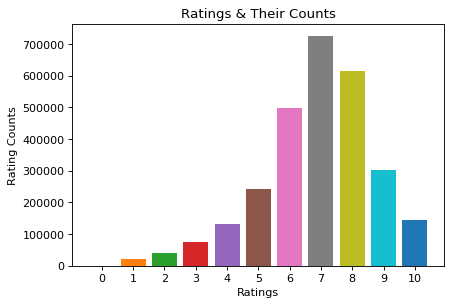

In [6]:
figure = plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k').add_subplot()        
figure.set_xlabel('Ratings')
figure.set_title('Ratings & Their Counts')
figure.set_ylabel('Rating Counts')
figure.set_xticks(np.arange(0, 11, 1))
for rating in df_by_class: plt.bar(rating, df_by_class[rating].shape[0])

In [7]:
all_data_df = all_data_df.loc[all_data_df['rating'] >= 1]

df_by_class = Get_DF_byClass(all_data_df)

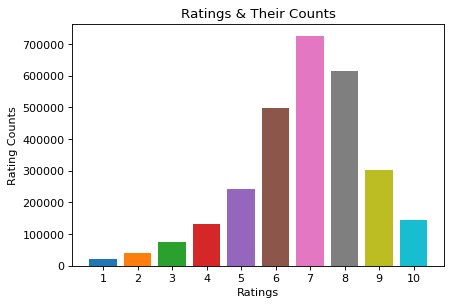

In [8]:
figure = plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k').add_subplot()        
figure.set_xlabel('Ratings')
figure.set_title('Ratings & Their Counts')
figure.set_ylabel('Rating Counts')
figure.set_xticks(np.arange(0, 11, 1))
for rating in df_by_class: plt.bar(rating, df_by_class[rating].shape[0])

In [9]:
print('\nafter removing classes less than 1')
total = 0
for rating in df_by_class:
    print('   rating: ' + str(rating), 'count: ' + str(df_by_class[rating].shape[0]))
    total += df_by_class[rating].shape[0]

print('\ntotal data count: ', total, '\n')

after removing classes less than 1
   rating: 1 count: 20073
   rating: 2 count: 38921
   rating: 3 count: 74425
   rating: 4 count: 130362
   rating: 5 count: 242860
   rating: 6 count: 496911
   rating: 7 count: 726467
   rating: 8 count: 614929
   rating: 9 count: 301233
   rating: 10 count: 144029

total data count:  2790210


### Scaling Down our Data Size, but Maintaining Proportions

In [10]:
def Get_Scaled_Data(df, N):
    
    df_by_class = Get_DF_byClass(df)
    
    total_size = 0
    for key in df_by_class: total_size += df_by_class[key].shape[0]
        
    scaled_df = []; scale = N / total_size
    for rating in df_by_class:
        
        i = int(df_by_class[rating].shape[0] * scale)
        scaled_df.append(df_by_class[rating][0:i])
        
    scaled_df = pd.concat(scaled_df).sample(frac=1).reset_index(drop=True)
    
    return scaled_df




N = 500000
scaled_df = Get_Scaled_Data(all_data_df, N)

df_by_class = Get_DF_byClass(scaled_df)

total = 0; print()
for rating in df_by_class:
    print('   rating: ' + str(rating), 'count: ' + str(df_by_class[rating].shape[0]))
    total += df_by_class[rating].shape[0]

print('\ntotal data count: ', scaled_df.shape[0])

   rating: 1 count: 3753
   rating: 2 count: 7533
   rating: 3 count: 14548
   rating: 4 count: 25732
   rating: 5 count: 49883
   rating: 6 count: 108142
   rating: 7 count: 163578
   rating: 8 count: 139790
   rating: 9 count: 67948
   rating: 10 count: 29212

total data count:  499996


In [11]:
def Split_DF_as_XY(df, train, dev, test):
    
    df = df.sample(frac=1).reset_index(drop=True)
    original_len = df.shape[0]
    i = int(train * original_len)
    
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    
    train_df = df[:i].sample(frac=1).reset_index(drop=True)
    vectorizer.fit(train_df['comment'])
    
    x_train = vectorizer.transform(train_df['comment'])
    y_train = np.asarray(train_df['rating'])
    
    df = df[i:].sample(frac=1).reset_index(drop=True)
    i = int(dev * original_len)
    
    dev_df = df[:i].sample(frac=1).reset_index(drop=True)
    x_dev = vectorizer.transform(dev_df['comment'])
    y_dev = np.asarray(dev_df['rating'])
    
    df = df[i:].sample(frac=1).reset_index(drop=True)
    i = int(test * original_len)
        
    test_df = df[:i].sample(frac=1).reset_index(drop=True)
    x_test = vectorizer.transform(test_df['comment'])
    y_test = np.asarray(test_df['rating'])
    
    return [vectorizer, x_train, y_train, x_dev, y_dev, x_test, y_test]




data_sets = Split_DF_as_XY(scaled_df, train=.7, dev=.15, test=.15)

### Deciding on a Classifier

# Experiment 1: Comparing Classifier Performance

In [55]:
accuracies = {}

def Ratings_toInt(ratings_float):
    
    ratings_int = ratings_float.astype(int)
    
    for i in range(ratings_float.shape[0]):
        
        distance = ratings_float[i] - float(ratings_int[i])
        if distance > .5: ratings_int[i] += 1
    
    return ratings_int

### Naive Bayes Performance

In [59]:
vectorizer, x_train, y_train, x_dev, y_dev, x_test, y_test = data_sets.copy()

y_train = Ratings_toInt(y_train)
y_dev = Ratings_toInt(y_dev)


nb = MultinomialNB(alpha=1)
nb.fit(x_train, y_train)

y_pred = nb.predict(x_dev)

accuracy = accuracy_score(y_dev, y_pred)*100
accuracies['NB'] = accuracy
print('Naive Bayes accuracy: {:.3f}%\n'.format(accuracy))

Naive Bayes accuracy: 27.968%



### KNN Performance

In [56]:
vectorizer, x_train, y_train, x_dev, y_dev, x_test, y_test = data_sets.copy()

y_train = Ratings_toInt(y_train)
y_dev = Ratings_toInt(y_dev)


best_k = 0; highest_accuracy = 0
for k in [1, 2, 3, 5, 7, 9, 11, 17]:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train) 

    y_pred = knn.predict(x_dev)

    accuracy = accuracy_score(y_dev, y_pred)*100
    if accuracy > highest_accuracy: best_k = k; highest_accuracy = accuracy
    print('KNN k = ' + str(k) + ', accuracy: {:.3f}%\n'.format(accuracy))
print()

accuracies['KNN'] = highest_accuracy

KNN k = 1, accuracy: 28.574%

KNN k = 2, accuracy: 27.715%

KNN k = 3, accuracy: 27.676%

KNN k = 5, accuracy: 22.556%

KNN k = 7, accuracy: 23.423%

KNN k = 9, accuracy: 23.768%

KNN k = 11, accuracy: 24.122%

KNN k = 17, accuracy: 24.431%




### SVM Performance

In [57]:
vectorizer, x_train, y_train, x_dev, y_dev, x_test, y_test = data_sets.copy()

int_train = Ratings_toInt(y_train)
int_dev = Ratings_toInt(y_dev)


svm = LinearSVC()
svm.fit(x_train, int_train)

y_pred = svm.predict(x_dev)

accuracy = accuracy_score(int_dev, y_pred)*100
print('SVM accuracy: {:.3f}%\n'.format(accuracy))
accuracies['SVM'] = accuracy

SVM accuracy: 32.444%



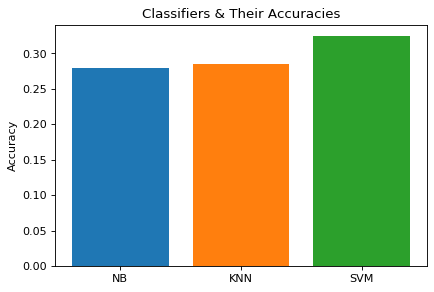

In [69]:
figure = plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k').add_subplot()        
figure.set_title('Classifiers & Their Accuracies')
figure.set_ylabel('Accuracy')
figure.set_xticklabels(['NB', 'KNN', 'SVM']) 

plt.bar('NB', accuracies['NB']/100)
plt.bar('KNN', accuracies['KNN']/100)
figure = plt.bar('SVM', accuracies['SVM']/100)
accuracies = []

# Experiment 2: Test SVM on a More Relaxed Problem

In [70]:
vectorizer, x_train, y_train, x_dev, y_dev, x_test, y_test = data_sets.copy()

int_train = Ratings_toInt(y_train)
b_train = np.asarray([1 if y >= 5 else 0 for y in int_train])

int_dev = Ratings_toInt(y_dev)
b_dev = np.asarray([1 if y >= 5 else 0 for y in int_dev])


svm = LinearSVC()
svm.fit(x_train, b_train)

y_pred = svm.predict(x_dev)

accuracy = accuracy_score(b_dev, y_pred)*100
accuracies.append(accuracy)
print('SVM: binary accuracy: {:.3f}%\n'.format(accuracy))

SVM: binary accuracy: 91.479%



# Experiment 3: Comparing SVM Performance as the Number of Classes Increase

In [71]:
vectorizer, x_train, y_train, x_dev, y_dev, x_test, y_test = data_sets.copy()

int_train = Ratings_toInt(y_train)
tri_train = []
for y in int_train:
    if y < 4: tri_train.append(0)
    elif y < 8: tri_train.append(1)
    else: tri_train.append(2)
tri_train = np.asarray(tri_train)

int_dev = Ratings_toInt(y_dev)
tri_dev = []
for y in int_dev:
    if y < 4: tri_dev.append(0)
    elif y < 8: tri_dev.append(1)
    else: tri_dev.append(2)
tri_dev = np.asarray(tri_dev)


svm = LinearSVC()
svm.fit(x_train, tri_train)

y_pred = svm.predict(x_dev)

accuracy = accuracy_score(tri_dev, y_pred)*100
accuracies.append(accuracy)
print('SVM: trinary accuracy: {:.3f}%\n'.format(accuracy))

SVM: trinary accuracy: 70.670%



In [72]:
vectorizer, x_train, y_train, x_dev, y_dev, x_test, y_test = data_sets.copy()

int_train = Ratings_toInt(y_train)
quad_train = []
for y in int_train:
    if y < 4: quad_train.append(0)
    elif y < 6: quad_train.append(1)
    elif y < 8: quad_train.append(2)
    else: quad_train.append(3)
quad_train = np.asarray(quad_train)

int_dev = Ratings_toInt(y_dev)
quad_dev = []
for y in int_dev:
    if y < 4: quad_dev.append(0)
    elif y < 6: quad_dev.append(1)
    elif y < 8: quad_dev.append(2)
    else: quad_dev.append(3)
quad_dev = np.asarray(quad_dev)


svm = LinearSVC()
svm.fit(x_train, quad_train)

y_pred = svm.predict(x_dev)

accuracy = accuracy_score(quad_dev, y_pred)*100
accuracies.append(accuracy)
print('SVM: quadnary accuracy: {:.3f}%\n'.format(accuracy))

SVM: quadnary accuracy: 58.371%



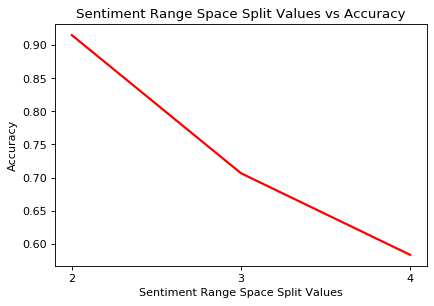

In [77]:
figure = plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k').add_subplot()        
figure.set_xlabel('Sentiment Range Space Split Values')
figure.set_title('Sentiment Range Space Split Values vs Accuracy')
figure.set_ylabel('Accuracy')
figure.set_xticks(np.arange(0, 5, 1))
figure = figure.plot([2, 3, 4], [accuracy/100 for accuracy in accuracies], color='red', linewidth=2)

# Experiment 4: Making the Contribution: a Layered SVM

In [16]:
class Major_Classifier:
    
    def __init__(self, vectorizer, C=1):
        
        self.vectorizer = vectorizer
        self.C = C
        
        return
    
    
    
    def Train(self, x_train, y_train):
        
        self.labels = [label for label in set([y for y in y_train])]
        self.labels.sort()
        
        self.classifiers = {}
        for label in self.labels:
            
            if label != 10:
                Y = np.asarray([0 if y > label else label for y in y_train])
            else:
                Y = np.asarray([0 if y < label else label for y in y_train])
                    
            self.classifiers[label] = LinearSVC(C=self.C)
            self.classifiers[label].fit(x_train, Y)
        
        return
    
    
    
    def Predict(self, X):
        
        if isinstance(X, scipy.sparse.csr.csr_matrix) != True:
            if isinstance(X, list) == False: X = [X]
            V = self.vectorizer.transform(X)
        else: V = X
        
        predictions = []
        for v in V:
            p = 0
            for label in self.labels:
                p = self.classifiers[label].predict(v)[0]
                if p == label: break
                        
            predictions.append(p)
        
        predictions = np.asarray(predictions)
        
        return predictions



vectorizer, x_train, y_train, x_dev, y_dev, x_test, y_test = data_sets.copy()

int_train = Ratings_toInt(y_train)
int_dev = Ratings_toInt(y_dev)


major_classifier = Major_Classifier(vectorizer)
major_classifier.Train(x_train, int_train)

p = major_classifier.Predict(x_dev)

a = accuracy_score(int_dev, p)*100
print('major classifier accuracy: {:.3f}%\n'.format(a))

major classifier accuracy: 35.160%



# Experiment 5: Hyperparameter Tuning


major classifier, C = 0.7, accuracy: 35.448%

major classifier, C = 0.5, accuracy: 35.719%

major classifier, C = 0.01, accuracy: 33.071%

major classifier, C = 0.001, accuracy: 28.726%


optimal value of C:  0.5
          accuracy: 35.719%



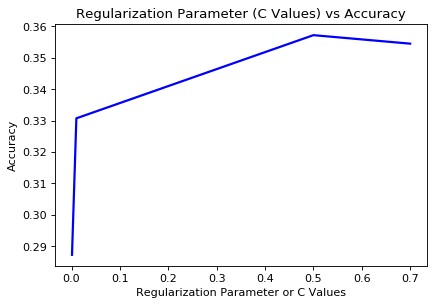

In [78]:
vectorizer, x_train, y_train, x_dev, y_dev, x_test, y_test = data_sets.copy()

int_train = Ratings_toInt(y_train)
int_dev = Ratings_toInt(y_dev)


accuracies = []; print()
for i, C in enumerate([.7, .5, .01, .001]):
    major_classifier = Major_Classifier(vectorizer, C)
    major_classifier.Train(x_train, int_train)

    p = major_classifier.Predict(x_dev)

    a = accuracy_score(int_dev, p)*100
    accuracies.append([C, a])
    print('major classifier, C = ' + str(C) + ', accuracy: {:.3f}%\n'.format(a))

C = []; A = []; max_a = 0; max_ai = 0; optimal_hyperparameter = 0
for i, (c, a) in enumerate(accuracies):
    C.append(c); A.append(a/100)
    if a > max_a: max_a = a; max_ai = i; optimal_hyperparameter = c

print('\noptimal value of C: ', C[max_ai])
print('          accuracy: {:.3f}%\n'.format(A[max_ai]*100))


figure = plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k').add_subplot()        
figure.plot(C, A, color='blue', linewidth=2)
figure.set_xlabel('Regularization Parameter or C Values')
figure.set_title('Regularization Parameter (C Values) vs Accuracy')
figure = figure.set_ylabel('Accuracy')

# Experiment 6: Performing the Final Evaluation & Checking for Overfit

In [35]:
final_test_data_sets = Split_DF_as_XY(all_data_df, train=.7, dev=.15, test=.15)

vectorizer, x_train, y_train, x_dev, y_dev, x_test, y_test = final_test_data_sets

int_train = Ratings_toInt(y_train)
int_test = Ratings_toInt(y_test)


major_classifier = Major_Classifier(vectorizer, optimal_hyperparameter)
major_classifier.Train(x_train, int_train)

p = major_classifier.Predict(x_test)

a = accuracy_score(int_test, p)*100
print('major classifier final accuracy: {:.3f}%\n'.format(a))

major classifier final accuracy: 35.654%



### Results and Conclusions
Results showed that Naïve Bayes and KNN where not the right classifiers for the kind
of data that was associated with this project even after moderate hyperparameters had
been located for each. In the end it was the Support Vector Machines that showed to
have any handle on the data. Without any hyperparameter tuning SVM was able to score
higher than Naïve Bayes and KNN with their optimal hyperparameters.

Yes, SVM’s accuracy was also low, approximately some 30%, however, with the developed
Major Classifier model with its optimal hyperparameters that I made for this project,
predictions could then be made with accuracies above 35% and almost to 36%. This is much
better than just randomly guessing which would select a correct answer some 10% of the
time.

In conclusion, I set out to see if I could create a version of a known classification
model that could calculate better accuracies than those of the classifications model
without my enhancements. I am pleased to say that I was able to create such a model and
contribute to an increased calculated accuracy.

# Challenges
This project presented many challenges as the data set was very large and very
difficult to predict. Many of the comments were quite long, non-english, and
not all encoded in the same format. As for the ratings, class representation was
not exactly even. The smallest range of values was 10 while the largest was closer
to 726470, so class representation was quite skewed. Also, many ratings went many
places behind the decimal point. To develop a model with such precision that could
deal with such issues could likely only be done with a Neural Network. Many questions
arrived as research began. Questions such as, Can this be done without a Neural
Network? Which classifier should be the starting point? How to achieve an increased
accuracy? What hyperparameters are necessary? Can I implement an optimization idea
to increase accuracy? Fortunately, all of these questions were able to be answered.
But the main questions were, Can a model be made to predict the data? Can this model’s
accuracy be increased? The answer to both of these challenges was yes. A model could
be made to predict the data and the accuracy could be increased by a layered SVM model.

# The Contribution
Because many classifiers performed so poorly with the given data, the main plan for
attack became to develop a model that could perform better and achieve higher accuracy.
The model I developed for this project ended up being a more layered version of SVM
that utilized multiple SVM classifiers that had been trained to give independent answers.

My algorithm involved using several SVM classifiers that were trained on the same data,
but with different labels for each classifier. Each classifier makes a binary decision
until an overall classification can be made. The model has 1 classifier for each class.
Each classifier is trained over the same data, however, for each classifier the rating
values, or the labels, are different. Each classifier attempts to decide whether the
comment's rating is on the left or the right side of the rating continuum. Once my
algorithm detects which side the rating is on, it makes a prediction or passes the
comment to the next classifier to make a more precise prediction.

Results demonstrated that with my developed algorithm, there was an increase in accuracy
of some 3%. After my classifier received hyperparameter tuning, there was another increase
in accuracy of almost 1%. Altogether my classifier makes predictions with accuracy that is
2.9-4% higher than that of the accuracy achieved by SVM on its own.

# References

• sklearn’s Naïve Bayes example:
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB

• sklearn’s KNN example:
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

• sklearn’s SVM example:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html